In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness

In [2]:
# ============ Load and Clean Data ============
dataset_dir = r"C:\Users\chenn\OneDrive\Desktop\btp\dataset_btp"
csv_path = os.path.join(dataset_dir, "BTP_1_Dataset.csv")
df = pd.read_csv(csv_path)

df["Power_to_Speed"] = df["Laser_Power"] / df["Scan_Speed"]
df["Energy_Density"] = df["Laser_Power"] / (df["Spot_Diameter"] * df["Scan_Speed"])
df["Flow_to_Cooling"] = df["Material_FlowRate"] / (df["Cooling_Rate"] + 1e-6)
df = df.drop(columns=['Stand_Off', 'Spot_Diameter', 'Material_FlowRate'])
df = pd.get_dummies(df, columns=['Material_Type'], prefix='Material')

numerical_features = ['Laser_Power', 'Scan_Speed', 'Cooling_Rate',
                      'Power_to_Speed', 'Energy_Density', 'Flow_to_Cooling']
categorical_features = [col for col in df.columns if col.startswith('Material_')]
features = numerical_features + categorical_features
targets = ['Aspect_Ratio', 'Dilution_Percent', 'PCE_Percent']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

IMAGE_SIZE = (224, 224)
def preprocess_image(path):
    full_path = os.path.join(dataset_dir, path) if not os.path.isabs(path) else path
    img = load_img(full_path, target_size=IMAGE_SIZE, color_mode='rgb')  # Force RGB
    img_array = img_to_array(img)
    img_array = effnet_preprocess(img_array)
    return img_array

image_arrays = np.array([preprocess_image(img_path) for img_path in df['Images']], dtype=np.float32)
X_num = df[features].values.astype(np.float32)
Y = df[targets].values.astype(np.float32)

X_num_train, X_num_test, X_img_train, X_img_test, Y_train, Y_test = train_test_split(
    X_num, image_arrays, Y, test_size=0.2, random_state=42
)

In [3]:
# ============ Build EfficientNetB0 Fusion Model ============
base_cnn = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg', input_shape=(224,224,3))
base_cnn.trainable = False  # Freeze weights for small dataset

img_input = Input(shape=(224,224,3), name='image_input')

# -----------------------------
# Data Augmentation Block
# -----------------------------
augmented = RandomFlip("horizontal_and_vertical")(img_input)
augmented = RandomRotation(0.2)(augmented)
augmented = RandomZoom(0.2)(augmented)
augmented = RandomBrightness(factor=0.2)(augmented)

# Pass augmented images to EfficientNetB0
img_features = base_cnn(augmented)
img_features = BatchNormalization()(img_features)
img_features = Dropout(0.3)(img_features)

num_input = Input(shape=(X_num_train.shape[1],), name='numerical_input')
x_num = Dense(64, activation='relu')(num_input)
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.3)(x_num)
x_num = Dense(32, activation='relu')(x_num)

combined = Concatenate()([x_num, img_features])
x = Dense(64, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='linear', name='output')(x)

model = Model(inputs=[num_input, img_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_flip (RandomFlip)      │ (None, 224, 224, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_rotation               │ (None, 224, 224, 3)       │               0 │ random_flip[0][0]          │
│ (RandomRotation)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numerical_input (InputLayer)  │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_zoom (RandomZoom)      │ (None, 224, 224, 3)       │               0 │ random_rotation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │             640 │ numerical_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_brightness             │ (None, 224, 224, 3)       │               0 │ random_zoom[0][0]          │
│ (RandomBrightness)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64)                │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetb0 (Functional)   │ (None, 1280)              │       4,049,571 │ random_brightness[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1280)              │           5,120 │ efficientnetb0[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │           2,080 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1280)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1312)              │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │          84,03

 Total params: 4,142,150 (15.80 MB)

 Trainable params: 89,763 (350.64 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

In [4]:
# ============ Train Model with Early Stopping ============
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
history = model.fit(
    [X_num_train, X_img_train], Y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 17s/step - loss: 956.8920 - mae: 25.4861 - val_loss: 918.4612 - val_mae: 25.1045
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step - loss: 956.6140 - mae: 25.6717 - val_loss: 912.6180 - val_mae: 25.0236
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 959.4702 - mae: 25.4985 - val_loss: 907.2238 - val_mae: 24.9450
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 948.3274 - mae: 25.3113 - val_loss: 902.5938 - val_mae: 24.8819
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 931.8488 - mae: 25.3620 - val_loss: 898.1476 - val_mae: 24.8341
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 946.0624 - mae: 25.4784 - val_loss: 894.1425 - val_mae: 24.7990
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 941.8361 - mae: 25.3413 - val_loss: 890.9388 - val_mae: 24.7689
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 936.2991 - mae: 25.2090 - val_loss: 887.9588 - val_mae: 24.7413
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

Aspect_Ratio Metrics:
  MAE: 0.519
  MSE: 0.316
  RMSE: 0.562
  R²: -1.180


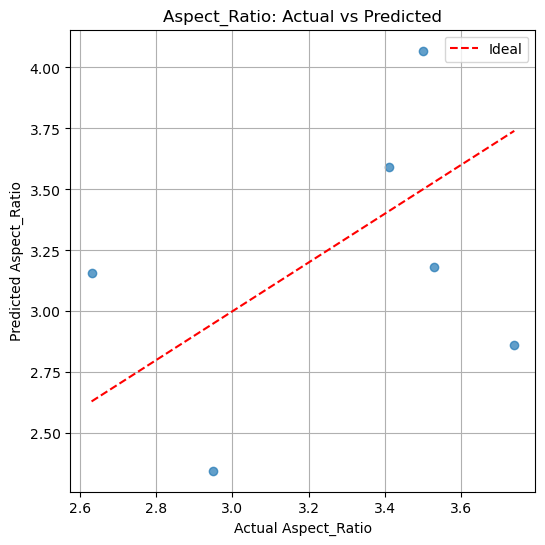

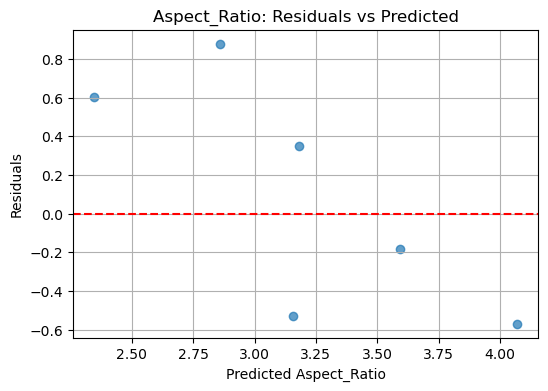


Dilution_Percent Metrics:
  MAE: 3.042
  MSE: 10.372
  RMSE: 3.221
  R²: 0.721


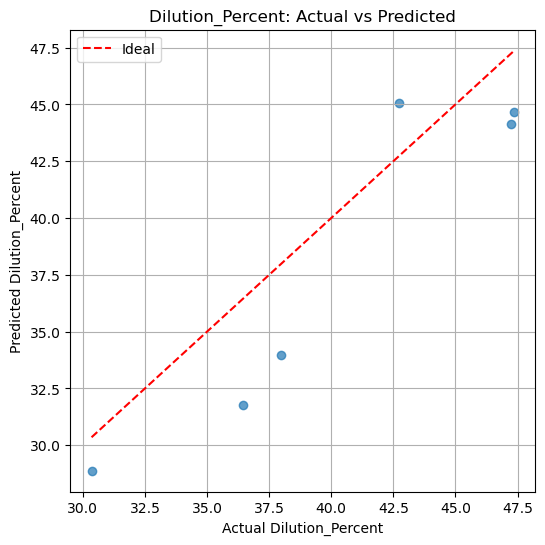

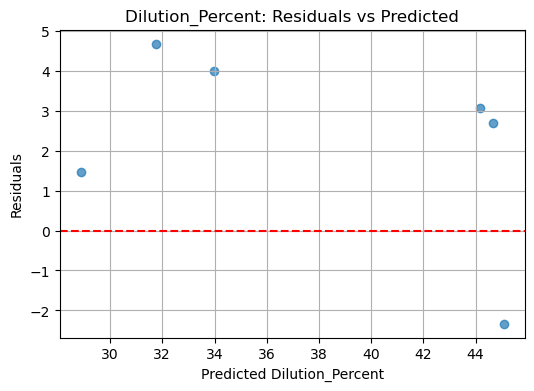


PCE_Percent Metrics:
  MAE: 2.770
  MSE: 13.267
  RMSE: 3.642
  R²: 0.851


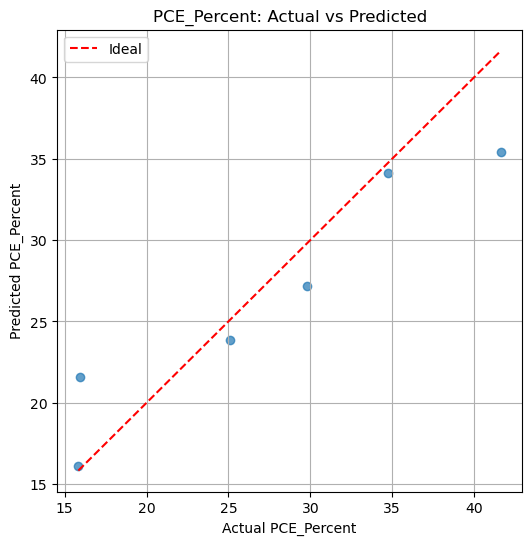

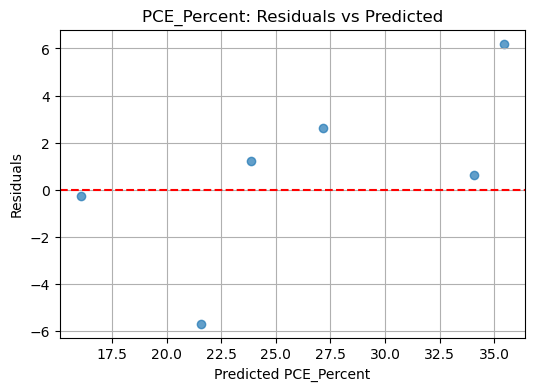

In [5]:
# Predict on test set
Y_pred = model.predict([X_num_test, X_img_test])

for i, target in enumerate(targets):
    mae = mean_absolute_error(Y_test[:, i], Y_pred[:, i])
    mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    print(f"\n{target} Metrics:")
    print(f"  MAE: {mae:.3f}")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²: {r2:.3f}")

    plt.figure(figsize=(6,6))
    plt.scatter(Y_test[:, i], Y_pred[:, i], alpha=0.7)
    plt.plot([Y_test[:, i].min(), Y_test[:, i].max()],
             [Y_test[:, i].min(), Y_test[:, i].max()],
             'r--', label='Ideal')
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"{target}: Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

    residuals = Y_test[:, i] - Y_pred[:, i]
    plt.figure(figsize=(6,4))
    plt.scatter(Y_pred[:, i], residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel(f"Predicted {target}")
    plt.ylabel("Residuals")
    plt.title(f"{target}: Residuals vs Predicted")
    plt.grid(True)
    plt.show()


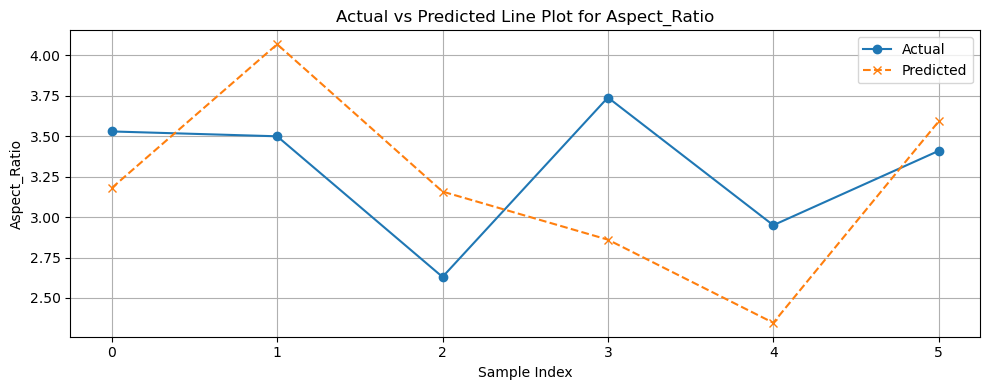

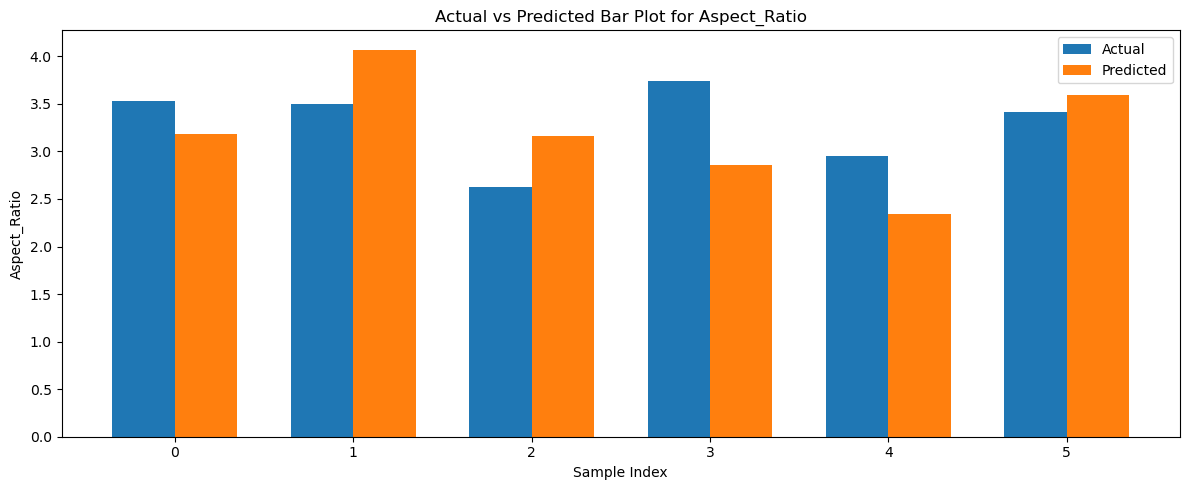

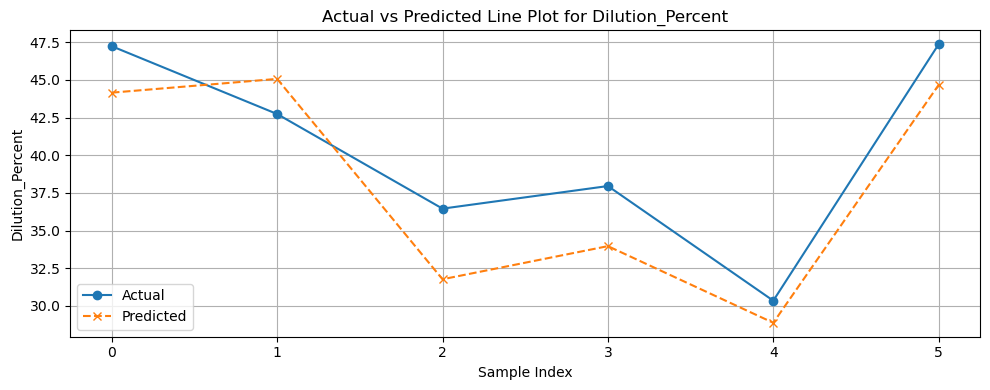

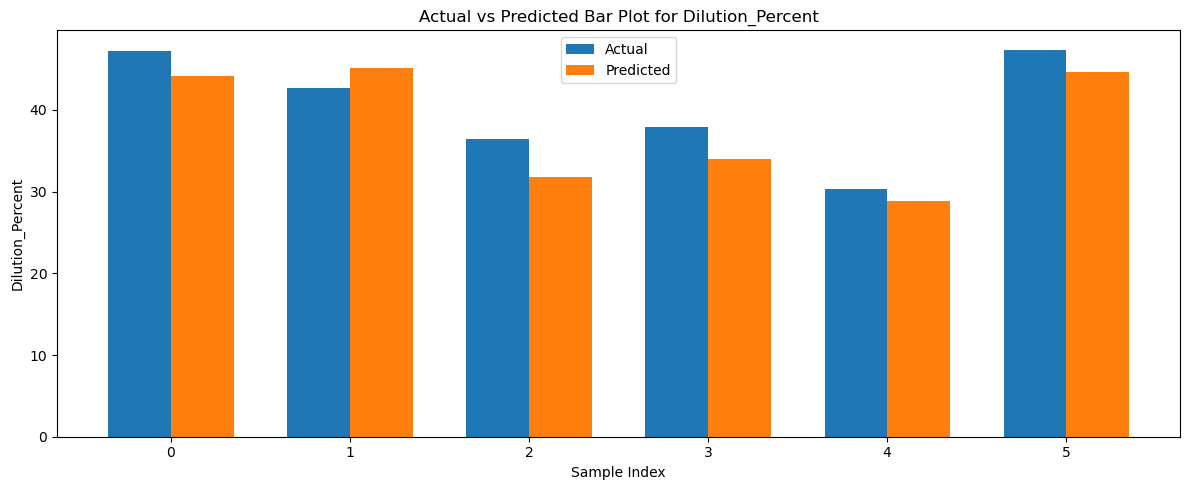

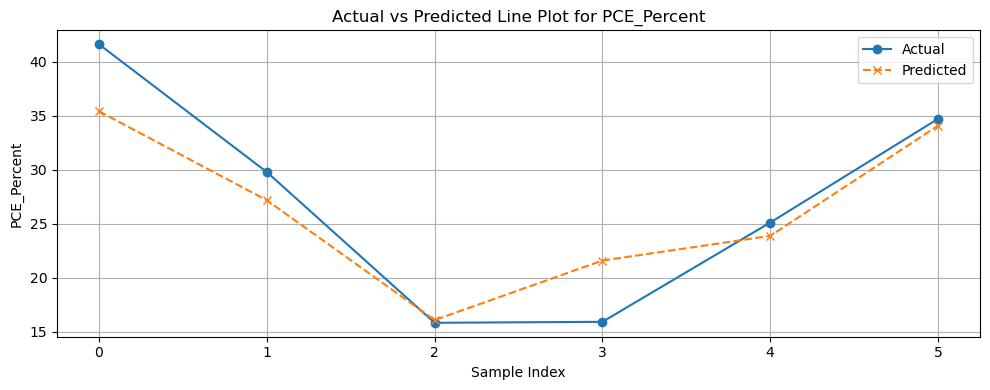

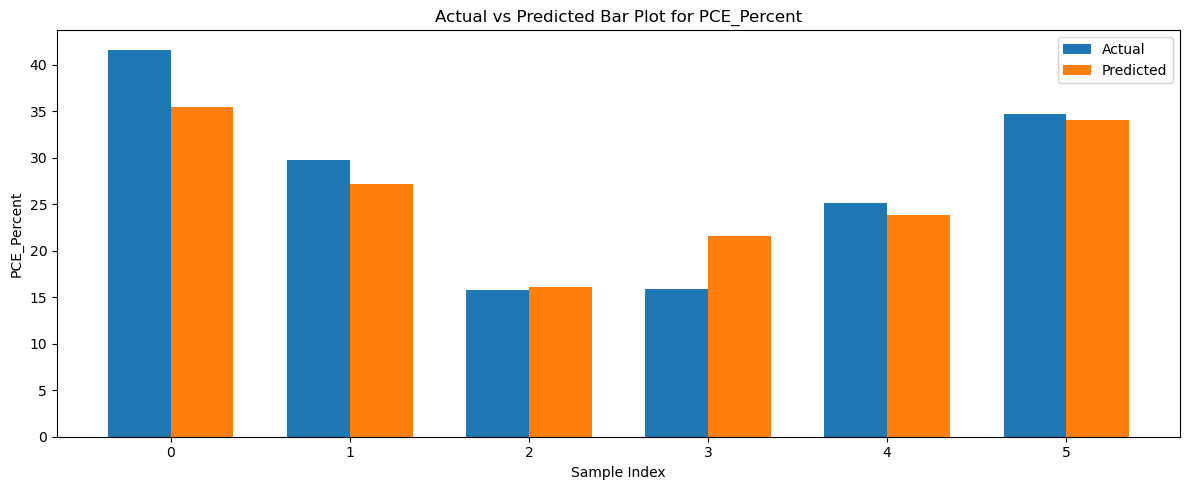

In [6]:
# Line and Bar plots for all targets
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[:, i], label='Actual', linestyle='-', marker='o')
    plt.plot(Y_pred[:, i], label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Line Plot for {target}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    x = np.arange(len(Y_test[:, i]))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, Y_test[:, i], width, label='Actual')
    plt.bar(x + width/2, Y_pred[:, i], width, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Bar Plot for {target}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
mse_total = np.mean((Y_test - Y_pred)**2)
print(f"Overall MSE (orig units): {mse_total:.4f}")

Overall MSE (orig units): 7.9851


In [9]:
# -----------------------------
#  Save model
# -----------------------------
model.save("early_fusion_efficientnetb0.keras")